<a href="https://colab.research.google.com/github/sollall/myidea/blob/master/%E6%A7%8B%E9%80%A0%E5%BC%8F%E3%83%A1%E3%83%BC%E3%82%AB%E3%83%BC%CE%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install condacolab
import condacolab
condacolab.install()

!mamba install -c conda-forge rdkit

from google.colab import output
output.clear()

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw

import copy
import re

In [39]:
input_data="C6H6"

atom_edge={"C":4,"N":3,"O":2,"Cl":1,"F":1}

In [40]:
#正規表現はhttps://analysis-navi.com/?p=2975　を参考にした
def atoms_counter(composition):
    #組成式を原子ごとに分解する
    content = eval("r"+"'"+composition+"'")
    pattern = '([A-Z][^A-Z]*)'

    repatter = re.compile(pattern)
    atoms = repatter.findall(content)

    #原子ごとに数を数える
    atoms_num={}
    for atom in atoms:
        specie = re.match(r"\D+", atom).group()
        num=atom.replace(specie,"")
        if num=="":
            num="1"
        num=int(num)
        if specie in atoms_num:
            atoms_num[specie]+=num
        else:
            atoms_num[specie]=num
    
    #渡す用のnodeを作る ほんとはsaiki側でやったほうがいい気がする
    node=[]
    all_hands=[]
    for specie,num in atoms_num.items():
        if specie!="H":
            node+=[specie]*num
            all_hands+=[atom_edge[specie]]*num
    H_num=atoms_num["H"]

    return node,all_hands,H_num

node_species,node_hands,H_num=atoms_counter(input_data)
print(node_species,node_hands,H_num)

['C', 'C', 'C', 'C', 'C', 'C'] [4, 4, 4, 4, 4, 4] 6


In [41]:
ans=[]

def connect_generator(i,j,connects,max_hand,H_num):
    
    if i==len(connects[0]):
        if sum(max_hand)-sum([sum(item) for item in connects])==H_num:
            temp=copy.deepcopy(connects)
            ans.append(temp)
            del temp
            pass
        return 
    
    elif j==len(connects[0]):
        connect_generator(i+1,i+1+1,connects,max_hand,H_num)

    else:
        hand=0
        connect_generator(i,j+1,connects,max_hand,H_num)
        a=max_hand[i]-sum(connects[i])
        b=max_hand[j]-sum(connects[j])
        for hand in range(min(a,b)):#ここのminがおかしい
            connects[i][j]+=1
            connects[j][i]+=1
            connect_generator(i,j+1,connects,max_hand,H_num)
        connects[i][j]=0
        connects[j][i]=0



In [42]:
connect_generator(0,1,[[0 for i in range(len(node_hands))] for j in range(len(node_hands))],node_hands, H_num)

print(ans)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [43]:
def dfs(graph,num,visited):
    if visited[num]==1:
        return
    else:
        visited[num]=1
        if sum(visited)==len(visited):
            shin_ans.append(copy.deepcopy(graph))
            return
        else:
            for index,item in enumerate(graph[num]):
                if item!=0:
                    dfs(graph,index,visited)
            

def check(graph):
    visited=[0]*len(graph)
    dfs(graph,0,visited)
    if sum(visited)==len(visited):
        return True
    else:
        return False

shin_ans=[]
for item in ans:
    check(item)


In [44]:
#https://cloud6.net/so/python/875586を改造
def MolFromGraphs(node_list, adjacency_matrix):
    
    # create empty editable mol object
    mol = Chem.RWMol()

    # add atoms to mol and keep track of index
    node_to_idx = {}
    for i in range(len(node_list)):
        a = Chem.Atom(node_list[i])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    # add bonds between adjacent atoms
    for ix, row in enumerate(adjacency_matrix):
        for iy, bond in enumerate(row):

            # only traverse half the matrix
            if iy <= ix:
                continue

            # add relevant bond type (there are many more of these)
            if bond == 0:
                continue
            elif bond == 1:
                bond_type = Chem.rdchem.BondType.SINGLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
            elif bond == 2:
                bond_type = Chem.rdchem.BondType.DOUBLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
            elif bond == 3:
                bond_type = Chem.rdchem.BondType.TRIPLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

    # Convert RWMol to Mol object
    mol = mol.GetMol()

    return mol

def GraphlistToSmiles(node,mols):
    ans=[Chem.MolToSmiles(MolFromGraphs(node,mol)) for mol in mols]
    ans=list(set(ans))
    return ans

mols=GraphlistToSmiles(node_species,shin_ans)

217


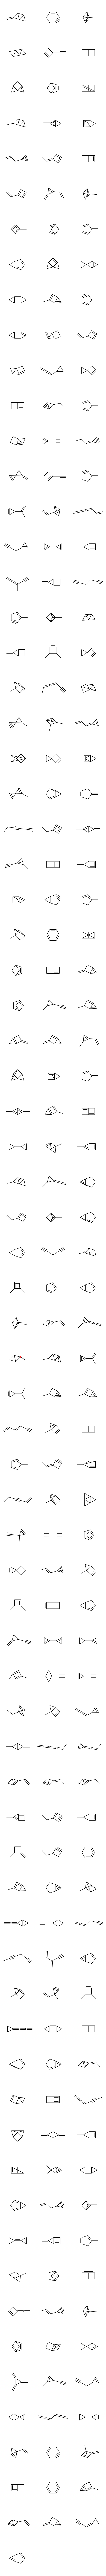

In [45]:
gets=[Chem.MolFromSmiles(item) for item in mols]

print(len(gets))
Draw.MolsToGridImage(gets)